In [1]:
import os, sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from category_encoders import OneHotEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning or RuntimeWarning)

## 1. 전처리

In [2]:
df = pd.read_parquet("../../after_light_prepro_Oct_Nov.parquet.gzip",
                     columns = ['event_type_view', 'event_type_purchase',  'event_type_cart',  'day', 'hour', 'week_day','brand', 'price', 'category_code', 'category_code_0'])

In [3]:
df.reset_index(drop = True, inplace = True)
df["category_code_1"] = df["category_code"].apply(lambda x : x.split(".")[1] if len(x.split(".")) > 1 else np.nan)
df["category_code_2"] = df["category_code"].apply(lambda x : x.split(".")[2] if len(x.split(".")) > 2 else np.nan)
df["category_code_3"] = df["category_code"].apply(lambda x : x.split(".")[3] if len(x.split(".")) > 3 else np.nan)
df.head()

,event_type_view,event_type_purchase,event_type_cart,day,hour,week_day,brand,price,category_code,category_code_0,category_code_1,category_code_2,category_code_3
0,1,0,0,1,4,1,shiseido,35.79,missing,missing,NaN,NaN,NaN
1,1,0,0,1,4,1,aqua,33.20,appliances.environment.water_heater,appliances,environment,water_heater,NaN
2,1,0,0,1,4,1,missing,543.10,furniture.living_room.sofa,furniture,living_room,sofa,NaN
3,1,0,0,1,4,1,lenovo,251.74,computers.notebook,computers,notebook,NaN,NaN
4,1,0,0,1,4,1,apple,1081.98,electronics.smartphone,electronics,smartphone,NaN,NaN


## 2. 시간에 따른 행동유형(요일/날짜/시간)

### 1) 요일별 User 행동유형 파악 


In [4]:
df_week_day = df[['event_type_view', 'event_type_purchase', 'event_type_cart', 'week_day']]
df_week_day["tot_event"] = df_week_day.event_type_view + df_week_day.event_type_purchase + df_week_day.event_type_cart

<ipython-input-4-87d0445c88dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_day["tot_event"] = df_week_day.event_type_view + df_week_day.event_type_purchase + df_week_day.event_type_cart


In [5]:
df_week_day.groupby("week_day", as_index=False).sum()

,week_day,event_type_view,event_type_purchase,event_type_cart,tot_event
0,0,12242413,202611,371228,12816252
1,1,13274344,210522,371401,13856267
2,2,13112462,216243,369670,13698375
3,3,13565151,210380,437812,14213343
4,4,17698275,207342,892559,18798176
5,5,17841592,259029,780136,18880757
6,6,16601272,353661,732640,17687573


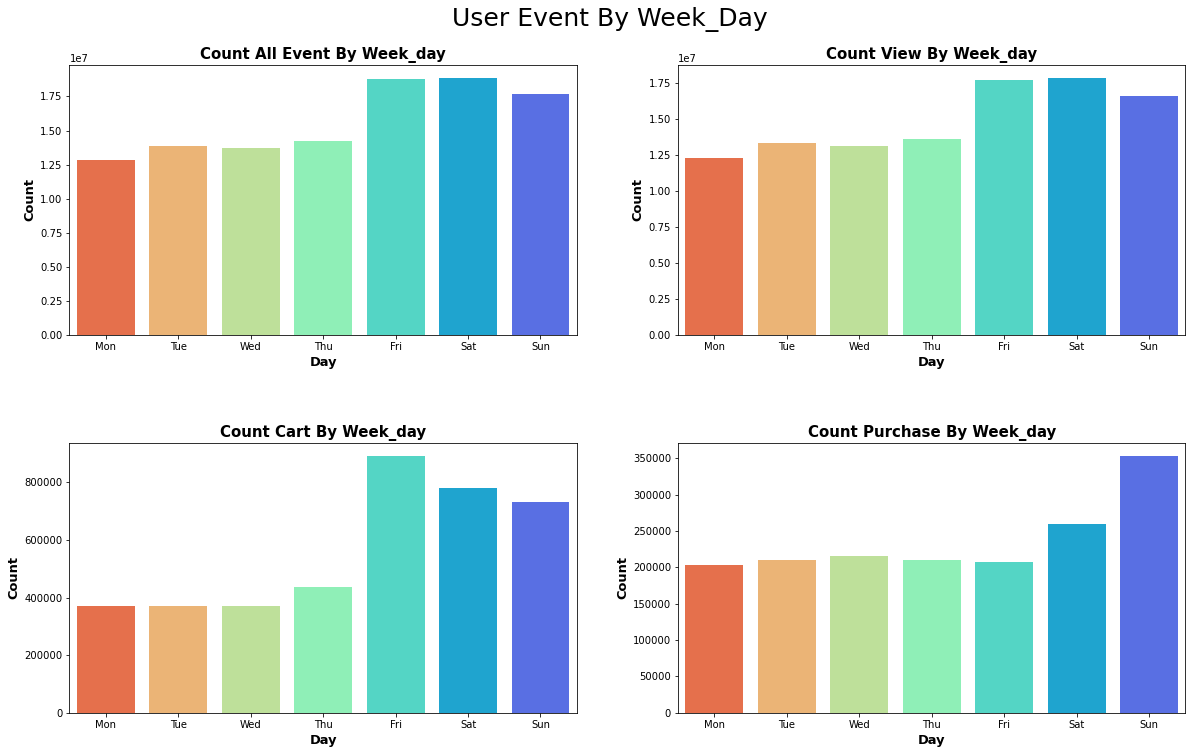

In [6]:
fig, ax = plt.subplots(2,2 , figsize=(20, 10))
fig.suptitle('User Event By Week_Day', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)


#요일별 모든종류의 이벤트
event_date = sns.barplot(x='week_day', y= 'tot_event', data=df_week_day.groupby("week_day", as_index=False).sum(), palette='rainbow_r', ax = ax1)
event_date.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

event_date.set_xlabel('Day', fontsize = 13, fontweight = 'bold')
event_date.set_ylabel('Count', fontsize = 13, fontweight = 'bold')
event_date.set_title('Count All Event By Week_day', fontsize = 15, fontweight = 'bold')


#요일별 조회
view_date = sns.barplot(x='week_day', y= 'event_type_view', data=df_week_day.groupby("week_day", as_index=False).sum(), palette='rainbow_r', ax = ax2)
view_date.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

view_date.set_xlabel('Day', fontsize = 13, fontweight = 'bold')
view_date.set_ylabel('Count', fontsize = 13, fontweight = 'bold')
view_date.set_title('Count View By Week_day', fontsize = 15, fontweight = 'bold')


#요일별 장바구니저장
cart_date = sns.barplot(x='week_day', y= 'event_type_cart', data=df_week_day.groupby("week_day", as_index=False).sum(), palette='rainbow_r', ax = ax3)
cart_date.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

cart_date.set_xlabel('Day', fontsize = 13, fontweight = 'bold')
cart_date.set_ylabel('Count', fontsize = 13, fontweight = 'bold')
cart_date.set_title('Count Cart By Week_day', fontsize = 15, fontweight = 'bold')


#요일별 구매
pur_date = sns.barplot(x='week_day', y= 'event_type_purchase', data=df_week_day.groupby("week_day", as_index=False).sum(), palette='rainbow_r', ax = ax4)
pur_date.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

pur_date.set_xlabel('Day', fontsize = 13, fontweight = 'bold')
pur_date.set_ylabel('Count', fontsize = 13, fontweight = 'bold')
pur_date.set_title('Count Purchase By Week_day', fontsize = 15, fontweight = 'bold')

plt.show;

### 2) 날짜별 User 행동유형 파악 

<function matplotlib.pyplot.show(close=None, block=None)>

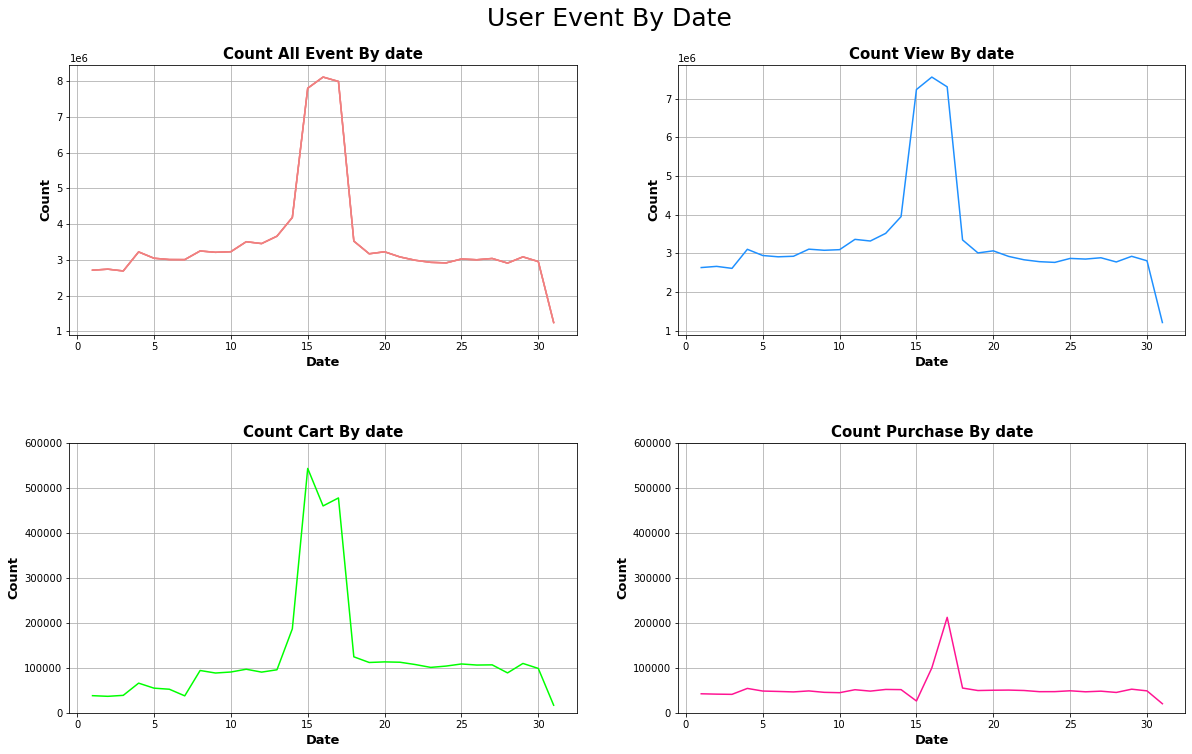

In [7]:
fig, ax = plt.subplots(2,2 , figsize=(20, 10))
fig.suptitle('User Event By Date', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')


#날짜별 모든종류의 이벤트
plt.subplot(221)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'day']].groupby("day").count(), color='lightcoral')
plt.title('Count All Event By date', fontsize = 15, fontweight = 'bold')
plt.xlabel('Date', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')


# 날짜별 조회
plt.subplot(222)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'day']].groupby("day").sum()["event_type_view"], color='dodgerblue')
plt.title('Count View By date', fontsize = 15, fontweight = 'bold')
plt.xlabel('Date', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')


# 날짜별 장바구니저장
plt.subplot(223)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'day']].groupby("day").sum()["event_type_cart"], color='lime')
plt.title('Count Cart By date', fontsize = 15, fontweight = 'bold')
plt.xlabel('Date', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')
plt.ylim(0, 600000)


# 날짜별 구매
plt.subplot(224)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'day']].groupby("day").sum()["event_type_purchase"],color='deeppink')
plt.title('Count Purchase By date', fontsize = 15, fontweight = 'bold')
plt.xlabel('Date', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')
plt.ylim(0, 600000)

plt.show

### 3) 시간대별 User 행동유형 파악

<function matplotlib.pyplot.show(close=None, block=None)>

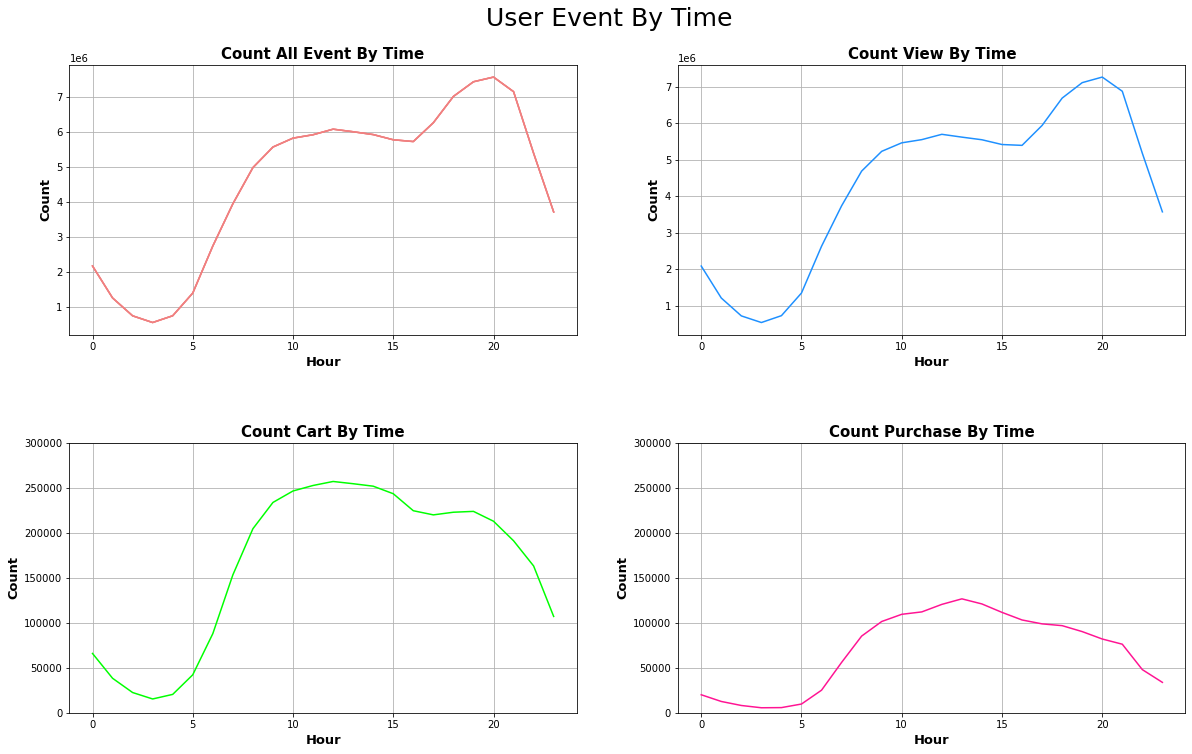

In [8]:
fig, ax = plt.subplots(2,2 , figsize=(20, 10))
fig.suptitle('User Event By Time', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

#시간대별 모든종류의 이벤트
plt.subplot(221)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'hour']].groupby("hour").count(), color='lightcoral')
plt.title('Count All Event By Time', fontsize = 15, fontweight = 'bold' )
plt.xlabel('Hour', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')


# 시간대별 조회
plt.subplot(222)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'hour']].groupby("hour").sum()["event_type_view"], color='dodgerblue')
plt.title('Count View By Time', fontsize = 15, fontweight = 'bold' )
plt.xlabel('Hour', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')


# 시간대별 장바구니저장
plt.subplot(223)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'hour']].groupby("hour").sum()["event_type_cart"], color='lime')
plt.title('Count Cart By Time', fontsize = 15, fontweight = 'bold' )
plt.xlabel('Hour', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')
plt.ylim(0, 300000)


# 시간대별 구매
plt.subplot(224)
plt.grid(True)
plt.plot(df[['event_type_view',	'event_type_purchase', 'event_type_cart', 'hour']].groupby("hour").sum()["event_type_purchase"], color='deeppink')
plt.title('Count Purchase By Time', fontsize = 15, fontweight = 'bold' )
plt.xlabel('Hour', fontsize = 13, fontweight = 'bold')
plt.ylabel('Count', fontsize = 13, fontweight = 'bold')

plt.ylim(0, 300000)
plt.show

## 3. 카테고리별 매출 분석

### 1) 1차 카테고리별(category_code_0) 매출 비교 및 비중 파악

Total_Sales : 504922080.06


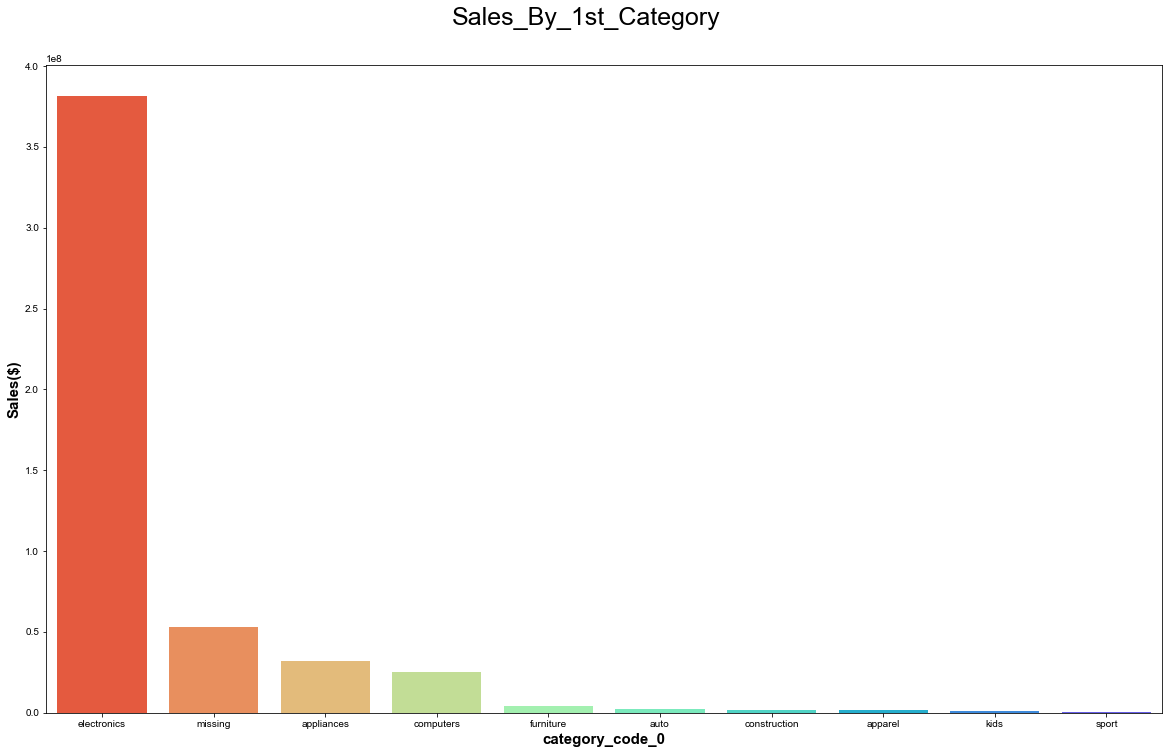

In [9]:
# 카테고리별 매출

df_category = df[['category_code_0', 'event_type_view', 'event_type_cart', 'event_type_purchase', 'price']]
df_category_sales = df_category[df_category["event_type_purchase"] > 0].groupby(["category_code_0"], as_index= False).sum()
df_category_sales_des = df_category_sales.sort_values('price', ascending=False)
category1_top10 = df_category_sales_des[['category_code_0', 'price']][:10]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Sales_By_1st_Category', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

sns.barplot(x='category_code_0', y= 'price', data=category1_top10, palette='rainbow_r')
sns.set(font_scale=1.8)

plt.xlabel('category_code_0', fontsize = 15, fontweight = 'bold')
plt.ylabel('Sales($)', fontsize = 15, fontweight = 'bold')
# plt.title('Sales_By_Category_code_0', fontsize = 15, fontweight = 'bold' )
plt.show;

print(f"Total_Sales : {category1_top10['price'].sum()}")

### 2) 2차 카테고리별(category_code_1) 매출 현황

Total_Sales : 436735722.21000004


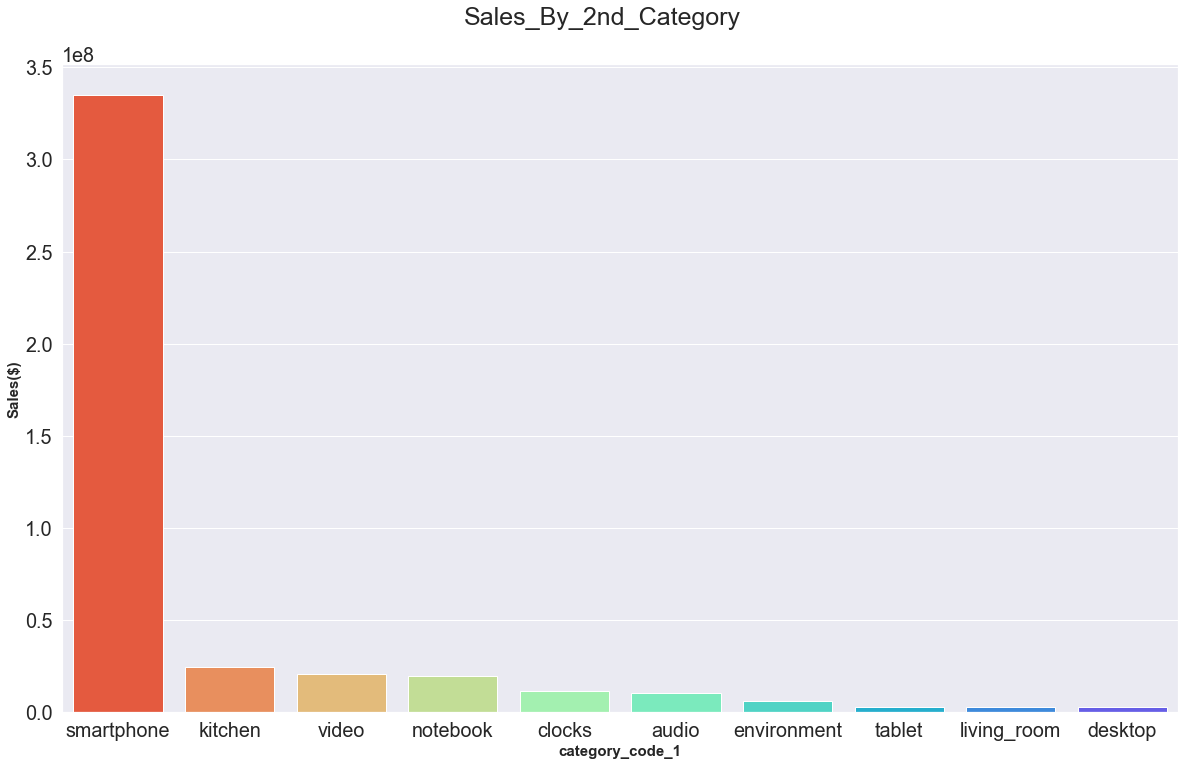

In [10]:
# 2차카테고리별 매출

df_category_2 = df[['category_code_1', 'event_type_view', 'event_type_cart', 'event_type_purchase', 'price']]
df_category_sales_2 = df_category_2[df_category_2["event_type_purchase"] > 0].groupby(["category_code_1"], as_index= False).sum()
df_category_sales_des_2 = df_category_sales_2.sort_values('price', ascending=False)
category2_top10 = df_category_sales_des_2[['category_code_1', 'price']][:10]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Sales_By_2nd_Category', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

sns.barplot(x='category_code_1', y= 'price', data=category2_top10, palette='rainbow_r')
sns.set(font_scale=1.8)

plt.xlabel('category_code_1', fontsize = 15, fontweight = 'bold')
plt.ylabel('Sales($)', fontsize = 15, fontweight = 'bold')
plt.show;

print(f"Total_Sales : {category2_top10['price'].sum()}")

### 3) 3차 카테고리별(category_code_2) 매출 현황

Total_Sales : 59108252.45999999


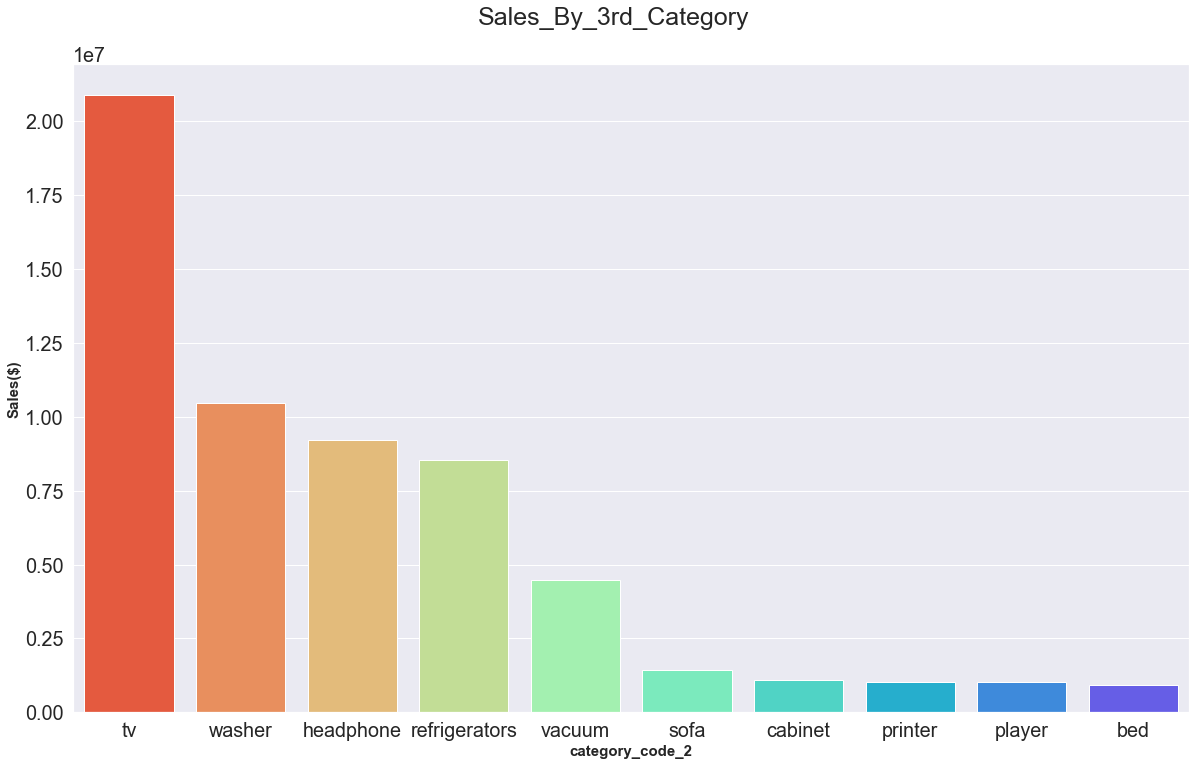

In [11]:
# 3차카테고리별 매출

df_category_3 = df[['category_code_2', 'event_type_view', 'event_type_cart', 'event_type_purchase', 'price']]
df_category_sales_3  = df_category_3[df_category_3["event_type_purchase"] > 0].groupby(["category_code_2"], as_index= False).sum()
df_category_sales_des_3 = df_category_sales_3.sort_values('price', ascending=False)
category3_top10 = df_category_sales_des_3[['category_code_2', 'price']][:10]


fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Sales_By_3rd_Category', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

sns.barplot(x='category_code_2', y= 'price', data=category3_top10, palette='rainbow_r')
sns.set(font_scale=1.8)

plt.xlabel('category_code_2', fontsize = 15, fontweight = 'bold')
plt.ylabel('Sales($)', fontsize = 15, fontweight = 'bold')
plt.show;

print(f"Total_Sales : {category3_top10['price'].sum()}")

## 4. 브랜드별 매출 분석

### 1) 브랜드별 매출 분석

Total_Sales : 424130591.56


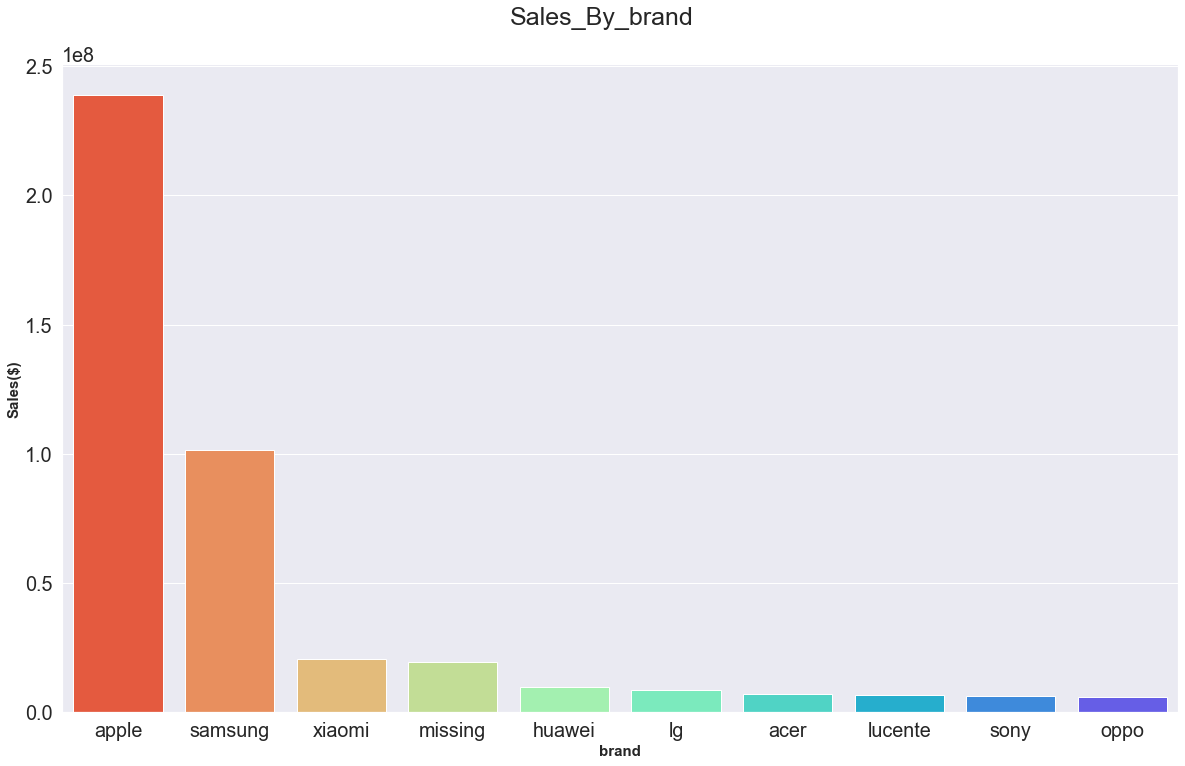

In [12]:
# 카테고리별 매출

df_brand = df[['brand', 'event_type_view', 'event_type_cart', 'event_type_purchase', 'price']]
df_brand_sales = df_brand[df_brand["event_type_purchase"] > 0].groupby(["brand"], as_index= False).sum()
df_brand_sales_des = df_brand_sales.sort_values('price', ascending=False)
brand_top10 = df_brand_sales_des[['brand', 'price']][:10]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Sales_By_brand', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

sns.barplot(x='brand', y= 'price', data=brand_top10, palette='rainbow_r')
sns.set(font_scale=1.8)

plt.xlabel('brand', fontsize = 15, fontweight = 'bold')
plt.ylabel('Sales($)', fontsize = 15, fontweight = 'bold')

plt.show;

print(f"Total_Sales : {brand_top10['price'].sum()}")